# 3.10.1 - Advanced - Geospatial Analysis

## Outline

### Prerequisites

-   Intermediate R skills
-   Theoretical understanding of multiple regression
-   Basic geometry

### Outcomes

After completing this notebook, you will be able to:

-   Manipulate geospatial objects in R using the `sf` package
-   Perform geospatial operations on real world data
-   Understand applications of geospatial analysis in the context of
    economic research

### References

-   [Geocomputation with R](https://r.geocompx.org/intro)

## Introduction

In this notebook, we’ll introduce the basics of geospatial analysis with
vector data. We’ll use the `sf` package and data from `spData` for our
examples.

In [ ]:
# load packages
library(tidyverse)
library(ggplot2)
library(sandwich)
library(lmtest)
library(sf)
library(spData)

# load self-tests
source('advanced_geospatial_tests.r')

## Part 1: Geospatial Data

Geospatial data is data coded to represent physical objects. For
example, let’s say we’re interested in analyzing the accessibility of
healthcare in BC. A dataset containing locations of emergency
departments (coded in longitude and latitude coordinates) and population
density per municipality would consitute a geospatial dataset. We could
use the geospatial data to estimate the share of BC residents within
10km of an emergency department. That analysis would involve calculating
relationships between physical objects (i.e., location of emergency
departments) and overlaying numeric data (i.e., population density per
municipality) on the physical objects.

The first step to learning how to conduct geospatial analyses like this
in R is to understand how geospatial data is stored - that’s what we’ll
cover in this section.

### Vector vs Raster Data

In R, geospatial data can be stored as either **vector data** or
**raster data**.

-   **Vector data** is coded in a collection of mathematical objects,
    such as points, lines, and polygons. Geospatial objects with vector
    data have discrete boundaries and are associated with specific
    locations through a **coordinate reference systems (CRS)**.
-   **Raster data** is coded as 2-D cells with constant size, called
    pixels. These pixels are accompanied with information that links
    them with a specific location.

Vector data is most widely used in the social sciences because
applications in politics or economics typically require discrete
boundaries of administrative regions (e.g., country or state borders).
For this reason, we’ll focus on conducting geospatial analysis with
vector data.

Vector data codes geospatial objects with the following elements:

-   **Points**, coded as `c(x, y)`: the most basic element, used when
    the area of the objects are not meaningful (e.g., locations of
    emergency departments in BC).
-   **Linestrings**, coded as `rbind(c(x1, y1), c(x2, y2), c(x3, y3))`:
    a series of points, used when the length of an object is meaningful
    but the area is not (e.g., rivers, roads).
-   **Polygons**, coded as
    `list(rbind(c(x1, y1), c(x2, y2), c(x3, y3), c(x1, y1)))`: a series
    of *closed* points, used when the area of an object is meaningful
    (e.g., Canadian provinces, metropolitan areas, protected areas).

> **Note**: to be closed objects, polygons need to start and end at the
> same points; notice above that the polygon starts at `c(x1, y1)` and
> also ends at `c(x1, y1)`.

What exactly are these (x, y) coordinates? How does R (and the user)
know which locations these coordinates represent?

### Coordinate Reference Systems

A coordinate reference system can be thought of as the base map in which
your geospatial objects will be overlayed. There are two main types of
CRS for vector data: **geographic CRS** and **projected CRS**.

-   **Geographic CRS** map locations with longitude and latitude
    coordinates. The x’s and y’s for the points, linestrings, and
    polygons introduced above will simply be longitude and latitude
    coordinates on the base map.

> **Note**: Geographic coordinates are spherical! This means that you
> cannot use the distance formula you learned in high-school to
> calculate the distance between two points coded in
> `c(longitude, latitude)` format. More on this later.

-   **Projected CRS** map locations with Cartesian coordinates on a flat
    surface. The x’s and y’s for the points, linestrings, and polygons
    introduced above will simply be x’s and y’s of a regular xy plane
    grid. There are different ways to project the earth on a flat
    surface, and that implies different ways to store objects and the
    relationships between them (e.g., conic, cylindrical, equidistant,
    equal-area…). More on this later.

### The `sf` package

The `sf` package is currently the most widely used package for
manipulating geospatial data in vector format in R. The package supports
all of the elements described above (i.e., points, linestrings,
polygons), as well as any combination of those objects (i.e.,
multipoints, multilinestrings, multipolygons, and geometry collections).
We’ll introduce them as needed throughout this notebook.

The beauty of the `sf` package is that it is compatible with
`tidyverse`: geometric objects are stored in dataframes, and we can
manipulate those objects with the typical `tidyverse` functions we use
with non-spatial datasets.

To illustrate, let’s create some geospatial data from scratch.

In [ ]:
# creating a point
a_point <- c(0,1)
class(a_point)

Let’s transform our point into a geospatial object using the
`st_point()` function.

In [ ]:
# transforming point into geospatial object
geo_point <- st_point(a_point)
geo_point
class(geo_point)

Notice that the data is coded as `POINT (0 1)` and the type of the
object is `sfg`, which stands for **simple feature geometry**. The
functions to transform R numeric vectors into `sfg` objects are:

-   `st_point()`
-   `st_linestring()`
-   `st_polygon()`

We can bind these `sfg` objects into a simple feature column with the
function `st_sfc()`.

In [ ]:
# creating two more points
another_point <- c(1,2)
yet_another_point <- c(3,3)

# transforming points into `sfg` objects
geo_point_2 <- st_point(another_point)
geo_point_3 <- st_point(yet_another_point)

# combining `sfg` objects into a simple feature column 
sfc_obj <- st_sfc(geo_point, geo_point_2, geo_point_3)
class(sfc_obj)

Now the type of the object is `sfc`. R also recognizes that it is a
`sfc_POINT`, because we only passed points to the simple features
column. Simple feature columns support different types of simple feature
objects in a same column (e.g., a column with a point, a linestring, and
a geometry collection).

Since we have coded our elements as geospatial data, we can now plot the
points in space.

In [ ]:
plot(sfc_obj)

Let’s take a look at the ouput of `sfc_obj`.

In [ ]:
sfc_obj

The output of this object gives us the following information:

-   We only have points as geometric objects in the column
-   The dimension of our objects is 2-D (i.e., we only passed 2
    coordinates for each point `c(x, y)`)
-   The bounds of our plot are `[c(0,1), c(3,1), c(3,3), c(0,3)]`
-   We have not specified a CRS (i.e., we don’t have a base map)

We can specify the CRS for our geometric data when creating the `sfc`
object with the parameter `crs`. Here, we have chosen the `crs`
“EPSG:4326”, which is a basic map of the world.

In [ ]:
sfc_obj_with_crs <- st_sfc(geo_point, geo_point_2, geo_point_3, crs = "EPSG:4326")
sfc_obj_with_crs

See now that R knows that our data refers to the Geodetic CRS WGS 84. A
simple search of the term will tell you that this is one of the most
widely used geographic CRS’s, in which the `c(x, y)` represents latitude
and longitude coordinates.

Once we specify the CRS, R knows which locations on Earth our geometric
objects refer to. This allows us to overlay objects we create on
existing geospatial objects that share the same CRS.

Let’s see this in practice. Let’s load the `world` dataset from the
`spData` package. We’ll use this dataset, which contains country
borders, to overlay two lines connecting Salvador, Brazil, to (1)
Luanda, Angola, and to (2) Maputo, Mozambique.

In [ ]:
# check the data and plot the `world` geometry
head(world)
plot(world["name_long"]) # specify that we want to plot the attribute `name_long`

We can see from the output above that the country boundaries are stored
as multipolygons, and that the CRS for the `world` geometry is WGS 84.

As shown earlier, the argument used to transform numeric vectors to this
CRS is `crs = "EPSG:4326"`. Let’s use that information to draw the lines
from Salvador to Luanda and Maputo and overlay them on the plot. We’ll
need the coordinates of these cities, which we can find by searching for
them online.

> **Note**: for this CRS, we need to specify the coordinates as
> `c(longitude, latitude)`. The longitude and latitude of Salvador are
> approximately `c(-38.5, -13)` and those of Luanda and Maputo are
> `c(13.2, -8.8)` and `c(32.6, -26)` respectively.

In [ ]:
# create lines with `st_linestring()`
line_luanda <- st_linestring(rbind(c(-38.5, -13), c(13.2, -8.8)))
line_maputo <- st_linestring(rbind(c(-38.5, -13), c(32.6, -26)))

# create simple feature column
lines_sfc <- st_sfc(line_luanda, line_maputo, crs = "EPSG:4326")

plot(world["name_long"], reset = FALSE)
plot(lines_sfc, add = TRUE, col ="red") # overlay the lines

The `plot()` function is the easiest way to plot geospatial objects in
R. The default of this function plots one map for each attribute (try
running `plot(world)` to see for yourself), so we specify `name_long` to
plot a single map for the output. The parameters `reset = FALSE` and
`add = TRUE` are needed to overlay plots.

### Geospatial Operations

We now turn our attention to objects that contain both simple features
and other data types as columns. The `world` dataset, which we used in
the previous section, has those features. Let’s examine this dataset
further.

In [ ]:
str(world)
class(world)

We can see that `world` contains the boundaries of countries as
multipolygons, but also contains attributes of those countries as other
types of data. Recognizing this, R categorizes this dataset as both `sf`
and `data.frame`.

We can create `sf` objects with categorical and numeric attributes using
the function `st_sf()`. Let’s show this by creating a custom dataset for
three cities in Portugal.

In [ ]:
# create a data.frame object containing the cities and their populations
city_attr <- data.frame(                   
  name = c("Lisboa", "Coimbra", "Porto"),
  population = c(545796, 106655, 231800)    
)

# specify points as c(lon, lat) coordinates of cities
l_coord <- st_point(c(-9.1, 38.7)) 
c_coord <- st_point(c(-8.4, 40.2))
p_coord <- st_point(c(-8.6, 41.1))

# create a column with the specified CRS
coordinates <- st_sfc(l_coord, c_coord, p_coord, crs = "EPSG:4326")  

# create `sf` object with the data.frame and the sfc
city_data <- st_sf(city_attr, geometry = coordinates)    
city_data

In [ ]:
class(city_data)

The image below illustrates the process of creating `sf` objects from
`sfc` and `data.frame` objects, which we did above.

<figure>
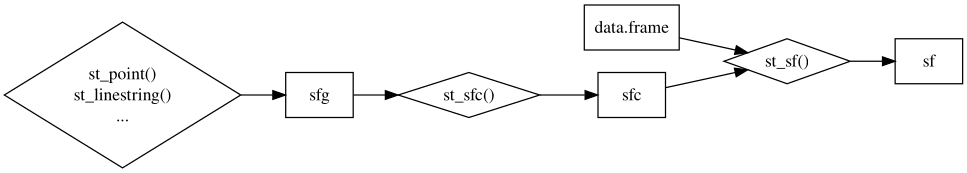
<figcaption aria-hidden="true">Lovelace, Robin and Nowosad, Jakub and
Muenchow, Jannes, (2019). Geocomputation with R.</figcaption>
</figure>

Now let’s suppose we want to merge `city_data` with data from the major
rivers in Portugal that pass through those cities.

> **Note**: These are not the actual coordinates of the rivers. The
> points are simulated and made so that they pass through the major
> cities.

In [ ]:
# creating river data
# data.frame object
river_names = data.frame(                           
  river_name = c("Tejo", "Mondego", "Douro")
)

# specify points as c(lon, lat) coordinates of rivers
t_coord <- st_linestring(rbind(c(-10, 37), c(-9.1, 38.7), c(-9.1, 39.3)))    
m_coord <- st_linestring(rbind(c(-8, 38.5), c(-8.4, 40.2), c(-7.8, 41.9)))
d_coord <- st_linestring(rbind(c(-8, 42),c(-8.6, 41.1), c(-8.8, 40)))

# create a column with the specified CRS
rivers <- st_sfc(t_coord, m_coord, d_coord, crs = "EPSG:4326")    

# create `sf` object with the data.frame and the sfc
river_data <- st_sf(river_names, river_geometry = rivers)    
plot(river_data)

One way of joining the data is to simply attach columns with `cbind()`.

In [ ]:
portugal_data <- cbind(city_data, river_data)
portugal_data

Another way to join datasets is through geospatial operations. These
operations allow us to filter, merge, or subset dataframes based on
whether points, lines, and polygons touch, intersect, or contain other
geospatial objects.

For example, let’s say we don’t know which river borders which city and
we want to use geospatial operations to find out. We can use `st_join()`
to merge both datasets based on intersections. `st_join()` is basically
a left join in which the matches are determined by the relationships
between the spatial objects.

In [ ]:
# merge city_data with river_data 
pt_data <- st_join(city_data, river_data["river_name"])    # specify "river_name" to keep it in the merged dataset
pt_data

`st_join()` assigns the names of the rivers to the observations in which
the point (i.e., city) intersects with the line (i.e., river).

> **Note**: `st_join()` drops the geometry of the second object.

Similar to `st_join()`, we can filter, merge, or subset `sf` objects
with other geospatial functions. The most common types of geospatial
operations are:

-   `st_intersects()`
-   `st_disjoin()`
-   `st_contains()`
-   `st_overlaps()`
-   `st_within()`

You can learn more about the different geospatial operations in the
[documentation of the
package](https://r-spatial.github.io/sf/reference/st_join.html).

### Test your Knowledge

Create a polygon with vertices (0,0), (0,3), (3,6), (6,3), (6,0). Your
answer must be a `sfg` object.

In [ ]:
polygon_1 <- st_...(...(...(...)))

answer_1 <- polygon_1

test_1()

Determine whether the following points are contained in the polygon with
a geospatial operation.

In [ ]:
point_1 <- st_point(c(0,0))
point_2 <- st_point(c(3,4))
point_3 <- st_point(c(3,3))
point_4 <- st_point(c(4,5))
point_5 <- st_point(c(6,6))
points <- st_sfc(point_1, point_2, point_3, point_4, point_5)

> **Hint**: you only need to run one function.

In [ ]:
answer_2 <- st_...(...)

test_2()

> **Think Deeper**: once you get to the correct answer of question 2,
> inspect the output of `answer_2`. What does it mean? How is it
> different than the intersection of two objects?

Which of the following functions should be used to create an object with
a simple feature column and other attributes?

1.  `as_data_frame()`
2.  `st_sfg()`
3.  `st_sfc()`
4.  `st_sf()`

In [ ]:
# Replace ... by your answer of "A", "B", "C" or "D"
answer_3 <- "..."

test_3()

What are the common coordinate inputs for geographic CRS?

1.  `c(lat, lon)`
2.  `c(lon, lat)`
3.  `c(x, y)`
4.  `c(y, x)`

In [ ]:
# Replace ... by your answer of "A", "B", "C" or "D"
answer_4 <- "..."

test_4()

## Part 2: Hedonic Pricing with Data from Athenian Properties

In this section, we’re going to estimate the value of apartment
characteristics with a hedonic pricing function for apartments located
in Athens, Greece. We’ll use the geospatial datasets `depmunic` and
`properties` from the package `spData`.

### Theory

Typically, economists rely on market prices to estimate consumers’
marginal willingness to pay for a good. When the good in question is not
traded in markets, economists must resort to other strategies. One of
those strategies is the **hedonic pricing method**.

The main assumption of hedonic pricing is that *the total price of a
good equals the sum of the prices of its components*. Using this
assumption, we can deconstruct the price of a good traded in markets and
attribute part of the total price to each of its non-traded component
parts. For example, we can model the price of an apartment as a function
of it’s size, view, age, location, number of bathrooms, proximity to
public service, etc. If we take two apartments that are exactly equal
but only differ on their view (e.g., one might be in the 2nd floor and
the other on the 30th floor of the same building), their difference in
price must be the added value of the view. If we have data on the prices
and attributes of several apartments, we could leverage hedonic pricing
to estimate how much consumers value a nice view.

> **Think Deeper**: what are the other underlying assumptions of hedonic
> pricing? When might it not be appropriate to use this method to value
> non-traded goods?

A model for the hedonic price of an apartment could be estimated with
the following regression:

$$
P_{i} = \beta_{0} + \beta_{1} Size_{i} + \beta_{2} Age_{i} + \beta_{3} Bath_{i} + \beta_{4} View_{i} + \beta_{5} Room_{i} + \beta_{6} Park_{i} + ... + \beta_{k} X_{ki}
$$

where

-   $P_{i}$ is the price per square meter of apartment $i$
-   The variables $Size$, $Age$, $Bath$, $View$, $Room$, $Park$, $...$,
    $X_{k}$ are the components of the apartment
-   The $\beta_{k}$s are the effects of those components on the price of
    the apartment

With that in mind, let’s try to estimate the hedonic pricing function of
apartments in Athens.

### Exploratory Analysis

Let’s load two datasets from the `spData` package.

-   `depmunic` has information on the 7 districts of the municipality of
    Athens. The district boundaries are stored in the data as polygons.
-   `properties` has data on properties for sale in the city of Athens.
    Property locations are stored in the data as points.

Let’s start with `depmunic`.

In [ ]:
head(depmunic)
str(depmunic)

We can see that the dataset has attributes of the districts: `airbnb`,
`museums`, `population`, …

We can also see that the CRS used for this dataset is a Greek CRS:
Projected CRS: GGRS87 / Greek Grid. This tells us that we’re dealing
with a projected CRS tailored to Greece. A quick search will find that
the units of reference are in meters.

> **Note**: a crucial part of geospatial data exploration is learning
> about the CRS of the dataset. This not only affects the relationships
> within your own dataset but also determines whether you can merge or
> filter geospatial objects based on other datasets.

Let’s plot the `depmunic` data. We specify the attribute greenspace
`["greensp"]` to plot a chart of the green space exclusively.

In [ ]:
plot(depmunic["greensp"])

The plot shows that the district in yellow (district 2) is the one with
largest greenspace, almost 10 times as much as the district in dark blue
(district 4).

Now let’s take a look at our `properties` data.

In [ ]:
head(properties)
str(properties)

We can see that the dataset has attributes of the properties: `size`,
`price`, `age`, …

We can see that the CRS used for this dataset is also the Greek CRS.
This is good news: both our datasets are referenced to the same grid.

Let’s plot our `properties` dataset.

In [ ]:
plot(properties["prpsqm"])

The plot shows the distribution of properties with their color
representing the price per square meter `prpsqm`. It’s hard to see a
pattern from this chart, but it seems that most of the expensive
properties are located towards the south.

Let’s plot our property locations on top of our district boundaries.

In [ ]:
plot(depmunic["num_dep"], reset = FALSE)
plot(properties["price"], add = TRUE, col = "darkgreen")

### Empirical Methods

Let’s try to put together a model to explain the price of properties in
Athens using the hedonic pricing method. Our proposed specification will
be: $$
P_{i} = \beta_0 + \beta_1 Size_{i} + \beta_2 Age_{i} + \beta_{3} Dist_{i} + \sum_{j=2}^{7} \gamma_{j} D_{ij} + \epsilon
$$

where

-   $P_{i}$ is the price (in euros) per square meter of apartment $i$,
-   $Size_{i}$ is the size in square meters of apartment $i$,
-   $Age_{i}$ is the age in years of apartment $i$,
-   $Dist_{i}$ is the distance between apartment $i$ and the closest
    metro in meters,
-   $D_{ij}$ are dummy variables indexing the districts $j$ for
    apartment $i$.

The dummy variables are included to account for district-specific
characteristics, such as the number of museums, parks, area of
greenspace, and other district specific factors that we don’t have data
on.

Looking at our `properties` dataset, we see that we already have data on
all of our regressors except district location of the apartments. We
need to use what we learned about geospatial operations to assign a
categorical variable indicating district location to each property.

Below we use the function `st_join()` to merge both datasets based on
the intersection of the spatial elements, and pass the attribute
`num_dep` (the district number) to the merged dataset.

In [ ]:
# find location districts for each property
merged_data <- st_join(properties, depmunic["num_dep"])
merged_data

Notice that `st_join()` dropped the district boundaries. That is fine,
since `num_dep` already indicates where each property is located. As a
matter of fact, we don’t even need the points anymore. We only needed
them to connect the apartments to their district! Let’s clean our data
before running our model.

> **Note**: we should drop spatial objects with the function
> `st_drop_geometry()`, as opposed to `select()`.

In [ ]:
model_data <- merged_data %>%
                select(size, prpsqm, age, dist_metro, num_dep)%>%
                mutate(num_dep = as_factor(num_dep))%>%    # so that R understand that this is a categorical variable
                st_drop_geometry()
str(model_data)

### Results and Analysis

Now, we’re ready to run our hedonic pricing model. Let’s do that using
`lm()`. R will automatically create dummy variables for each district.

In [ ]:
model1 <- lm(prpsqm ~ size + age + dist_metro + num_dep, data = model_data)
coeftest(model1, vcov = vcovHC)

The most significant factor contributing to the price of an apartment in
Athens appears to be district location. Although age and distance to
metro are statistically significant, their effects are quite small (as
long as the property is not *super* old or *super* far from the closest
metro). However, we do see a wide range of effects for district
locations. Once we control for size, age, and distance from metro, the
mere fact of being in district 4 decreases the price per square meter by
over 1,000 euros! Maybe it’s the lack of greenspace that we have noted
earlier…

Our model breaks down the price of an apartment as follows:

$$
P_{i} = 2352 + 4.3 Size_{i} -20 Age_{i} -0.1 Dist_{i} + \sum_{i=2}^{7} \gamma_{i} D_{i} + e
$$

In which the added effects for the dummies are:

-   District 2: $-334$ euros
-   District 3: $-490$ euros
-   District 4: $-1031$ euros
-   District 5: $-822$ euros
-   District 6: $-918$ euros
-   District 7: $-653$ euros

District 1 is the base case (i.e., when all dummies equal zero), and is
the most accretive location to the price of a property. That makes
sense, since District 1 is the historic center of Athens.

Now, let’s look at how well our model actually predicts the price per
square meter of properties. This can shed light on the appropriateness
of using hedonic pricing strategies for properties in Athens.

In [ ]:
summary(model1)$adj.r.squared

Our adjusted $R^2$ says that our model only explains ~35% of the
variation in the price of properties in Athens. The cause of low
predictive power could be an error of methodology (prices of properties
in Athens might not be the sum of their component parts!), or a missing
variable problem.

> **Think Deeper**: what component parts of properties might we be
> missing in our hedonic pricing model?